# AutoEncoders

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

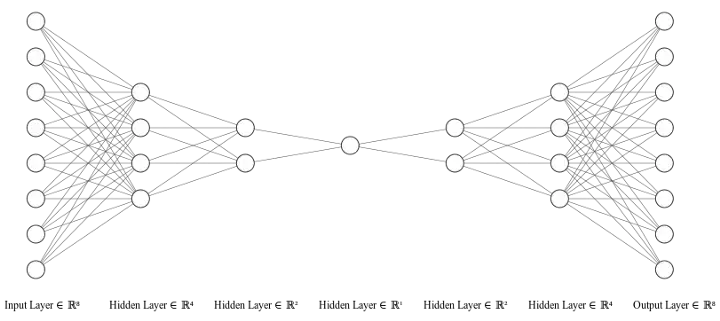

## Imports

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Device Agnostic Code

In [128]:
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [8]:
# Transforms images to a PyTorch tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root='./data',
                        train=True,
                        download=True,
                        transform=tensor_transform)
# DataLoader is used to load the dataset for training
loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=32,
                                    shuffle=True)

## EDA

In [14]:
dataset.data[0].shape

torch.Size([28, 28])

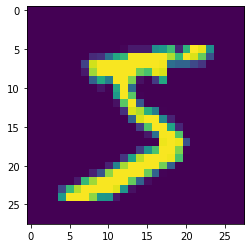

In [15]:
plt.imshow(dataset.data[0])

In [19]:
dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

## Autoencoder

In [92]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Building a linear encoder with Linear layers followed by ReLU
        # 28*28 = 784 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        
         # Building a linear decoder with Linear layers followed by ReLU
        # 9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 28*28 = 784
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

## Initialising the model

In [129]:
model = AE().to(device)

loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),
                       lr = 1e-1,
                       weight_decay=1e-8)

## Debugging

torch.Size([32, 784])


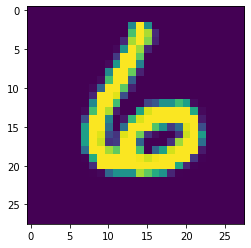

In [130]:
for (image, _) in loader:
    batch = image.reshape(-1, 28*28)
    print(batch.shape)
    plt.imshow(batch[0].reshape(-1, 28))
    break

torch.Size([3, 3])


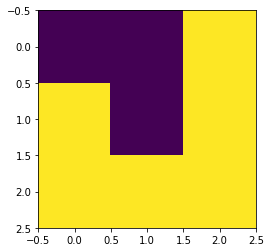

In [134]:
latent = model.encoder(batch.to(device))
print(latent[0].reshape(-1,3).shape)
plt.imshow(latent[0].cpu().reshape(-1,3) > 0)

torch.Size([28, 28])


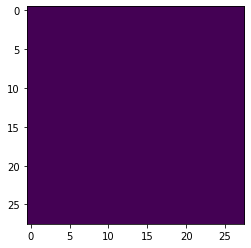

In [106]:
reconstructed = model(batch)
print(reconstructed[0].reshape(-1,28).shape)
plt.imshow(reconstructed[0].reshape(-1,28) > 0)

## Training the model

In [136]:
epochs = 20
outputs = []
losses = []

for epoch in tqdm(range(epochs)):
    for (image, _) in loader:
        # Send batch to device
        image = image.to(device)
        
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 784)
        
        # Forward pass
        reconstructed = model(image)
        
        # Calculating loss
        loss = loss_function(reconstructed, image)
        
        # The gradients are set to zero, back propagate, and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the losses in a list for plotting
        losses.append(loss)
    outputs.append((epochs, image, reconstructed))
    


100%|███████████████████████████████████████████| 20/20 [03:16<00:00,  9.81s/it]


In [138]:
for i, loss in enumerate(losses):
    losses[i] = loss.detach().cpu().numpy()

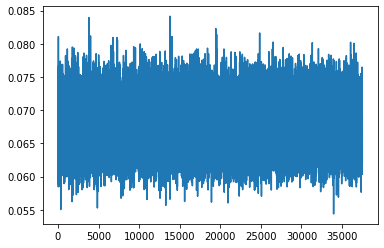

In [139]:
plt.plot(losses)